In [1]:
import math
import functools
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import qutip as qt
import time

In [2]:
opstr2fun = {'x': lambda dim: qt.spin_Jx((dim-1)/2),
             'y': lambda dim: qt.spin_Jy((dim-1)/2),
             'z': lambda dim: qt.spin_Jz((dim-1)/2),
             'p': lambda dim: qt.spin_Jp((dim-1)/2),
             'm': lambda dim: qt.spin_Jm((dim-1)/2),
             'i': qt.identity}
def mkSpinOp(dims, specs):
    ops = [qt.identity(d) for d in dims]
    for ind, opstr in specs:
        ops[ind] = ops[ind] * opstr2fun[opstr](dims[ind])
    return qt.tensor(ops)
def mkH1(dims, ind, parvec):
    axes = ['x', 'y', 'z']
    return functools.reduce(lambda a, b: a + b, 
               [v * mkSpinOp(dims, [(ind,ax)]) for v, ax in zip(parvec, axes) if v!=0])
def mkH12(dims, ind1, ind2, parmat):
    axes = ['x', 'y', 'z']
    ops = []
    for i in range(3):
        for j in range(3):
            if parmat[i,j] != 0:
                ops.append(parmat[i,j] * mkSpinOp(dims, [(ind1,axes[i]), (ind2,axes[j])]))
    return functools.reduce(lambda a, b: a + b, ops)

In [4]:
b0 = 1.4 * 2*math.pi
I = 1
A = np.diag([-2.6, -2.6, 49.2]) * 2*math.pi # Mrad/s
kr = 1. # 1/us
tmax = 20. / kr # us
tlist = np.linspace(0, tmax, math.ceil(1000*tmax))
B0 = b0 * np.array([1,0,0])

dims = [2, 2, 3]
dim = np.prod(dims)
Hzee = mkH1(dims, 0, B0) + mkH1(dims, 1, B0)
Hhfc = mkH12(dims, 0, 2, A)
H0 = Hzee + Hhfc
S12 = qt.singlet_state()
Ps = 1/4 * mkSpinOp(dims,[]) - mkH12(dims, 0, 1, np.identity(3))
Pt = mkSpinOp(dims,[]) - Ps

H = H0.data.todense()


In [5]:
kets0 = np.hstack([qt.tensor(S12, qt.basis(3, i)).data.todense() for i in range(0, 3)])

In [6]:
from scipy.integrate import ode

In [7]:
# this is roughly what qutip uses internally

fun = lambda t, psi: -1j * np.reshape(np.dot(H, np.reshape(psi, (dim, -1))), -1)

integrator = ode(fun).set_integrator('zvode', atol=1e-12, rtol=1e-10, method='adams', order=12)
integrator.set_initial_value(np.array(kets0).reshape(-1), 0.0)
traj = [(0.,3)]
dt = 0.001
start = time.time()
while integrator.successful() and integrator.t < tmax:
    kets = integrator.integrate(integrator.t + dt).reshape(dim, -1)
    traj.append((integrator.t, np.trace(np.dot(kets.transpose().conjugate(), Ps * kets))))
stop = time.time()
print("{} sec".format(stop - start))
tlist = np.array([x for x,y in traj])
ps = np.array([np.real(y) for x,y in traj]) / 3
yr = kr * sci.integrate.simps(ps * np.exp(-kr*tlist), tlist)
print(yr)

1.324970006942749 sec
0.4982131679761941


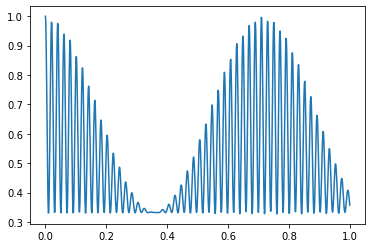

In [8]:
plt.plot(tlist[:1000], ps[:1000])